In [1]:
df <- read.csv(file = "deptos_agrupados2.csv", sep=',', header = T)

In [2]:
df$var2008 <- NULL
df$var2009 <- NULL
df$var2010 <- NULL
df$var2011 <- NULL
df$var2012 <- NULL
df$var2013 <- NULL
df$var2014 <- NULL
df$var2015 <- NULL

In [3]:
df$X.1 <- NULL
df$X <- NULL

In [4]:
df <- df[!is.na(df$varprom),]

In [5]:
df <- df[order(df$varprom),]

In [6]:
p <- (nrow(df)*5)/100

In [7]:
df$varprom <- 0
for (i in seq(from = (nrow(df) - p),to = nrow(df))){
    df$varprom[i] <- 1
}

In [8]:
table(df$varprom)


    0     1 
21602  1138 

### Construimos el modelo usando XGBoost

In [9]:
#install.packages("xgboost")
require(xgboost)

Loading required package: xgboost


In [10]:
library(data.table)

In [11]:
df_train <- df[df$ANIO != 2015,]
df_test <- df[df$ANIO == 2015,]

In [12]:
df_train$ANIO <- NULL
df_test$ANIO <- NULL

In [13]:
#convert data frame to data table
setDT(df_train) 
setDT(df_test)

In [14]:
df_train2 <- as.data.frame(scale(df_train[,-c("varprom"),with=F]))
df_test2 <- as.data.frame(scale(df_test[,-c("varprom"),with=F]))

In [15]:
df_train2$LAT <- NULL
df_train2$LON <- NULL
df_test2$LAT <- NULL
df_test2$LON <- NULL

In [16]:
#using one hot encoding 
tr_label <- df_train$varprom
ts_label <- df_test$varprom
new_tr <- model.matrix(~.+0,data = df_train2)
new_ts <- model.matrix(~.+0,data = df_test2)

In [17]:
#preparing matrix 
dtrain <- xgb.DMatrix(data = new_tr,label = tr_label) 
dtest <- xgb.DMatrix(data = new_ts,label = ts_label)

In [18]:
#default parameters
params <- list(booster = "gbtree", objective = "binary:logistic", eval_metric = "auc", eval_metric = "logloss", eta=0.2, max_depth=20, early_stopping_round = 10)

In [19]:
xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 2000, nthread = 2,nfold = 5)

[1]	train-auc:0.794733+0.017145	train-logloss:0.537849+0.000910	test-auc:0.741764+0.008095	test-logloss:0.542840+0.001948 
[2]	train-auc:0.841406+0.012281	train-logloss:0.432014+0.001319	test-auc:0.772226+0.013276	test-logloss:0.441772+0.002788 
[3]	train-auc:0.885203+0.008100	train-logloss:0.354072+0.001161	test-auc:0.795874+0.011757	test-logloss:0.369273+0.004284 
[4]	train-auc:0.917094+0.006657	train-logloss:0.295180+0.001654	test-auc:0.811203+0.012582	test-logloss:0.315511+0.005422 
[5]	train-auc:0.940027+0.009100	train-logloss:0.248520+0.001295	test-auc:0.836371+0.019422	test-logloss:0.273528+0.005477 
[6]	train-auc:0.959361+0.008914	train-logloss:0.210186+0.001089	test-auc:0.856473+0.016780	test-logloss:0.239915+0.006395 
[7]	train-auc:0.971182+0.006806	train-logloss:0.179359+0.001457	test-auc:0.869235+0.014103	test-logloss:0.213618+0.006991 
[8]	train-auc:0.983010+0.006702	train-logloss:0.153632+0.001236	test-auc:0.883736+0.014823	test-logloss:0.191675+0.007377 
[9]	train-auc:0.

In [20]:
#first default - model training
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 2000, nthread = 2, watchlist = list(val=dtest,train=dtrain), early_stopping_round = 10)
#model prediction
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.5,1,0)

[1]	val-auc:0.733495	val-logloss:0.546948	train-auc:0.810432	train-logloss:0.538509 
Multiple eval metrics are present. Will use train_logloss for early stopping.
Will train until train_logloss hasn't improved in 10 rounds.

[2]	val-auc:0.759924	val-logloss:0.448057	train-auc:0.839668	train-logloss:0.432489 
[3]	val-auc:0.789503	val-logloss:0.377894	train-auc:0.898795	train-logloss:0.354065 
[4]	val-auc:0.791622	val-logloss:0.326084	train-auc:0.938069	train-logloss:0.293959 
[5]	val-auc:0.830178	val-logloss:0.283184	train-auc:0.960368	train-logloss:0.245587 
[6]	val-auc:0.841445	val-logloss:0.250114	train-auc:0.970422	train-logloss:0.206481 
[7]	val-auc:0.856232	val-logloss:0.224332	train-auc:0.976011	train-logloss:0.174968 
[8]	val-auc:0.858957	val-logloss:0.205633	train-auc:0.980525	train-logloss:0.151236 
[9]	val-auc:0.868522	val-logloss:0.188625	train-auc:0.989432	train-logloss:0.129221 
[10]	val-auc:0.873059	val-logloss:0.175481	train-auc:0.993644	train-logloss:0.111280 
[11]	val-

In [21]:
as.data.frame(table(xgbpred))

xgbpred,Freq
0,2411
1,52


In [22]:
#install.packages("e1071")
library(caret)

Loading required package: lattice
Loading required package: ggplot2


In [23]:
#confusion matrix
confusionMatrix (xgbpred, ts_label)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2333   78
         1    2   50
                                          
               Accuracy : 0.9675          
                 95% CI : (0.9597, 0.9742)
    No Information Rate : 0.948           
    P-Value [Acc > NIR] : 2.116e-06       
                                          
                  Kappa : 0.5418          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9991          
            Specificity : 0.3906          
         Pos Pred Value : 0.9676          
         Neg Pred Value : 0.9615          
             Prevalence : 0.9480          
         Detection Rate : 0.9472          
   Detection Prevalence : 0.9789          
      Balanced Accuracy : 0.6949          
                                          
       'Positive' Class : 0               
                                          

In [24]:
#install.packages("pROC")
library(pROC)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [25]:
auc(ts_label, xgbpred)

Area under the curve: 0.6949

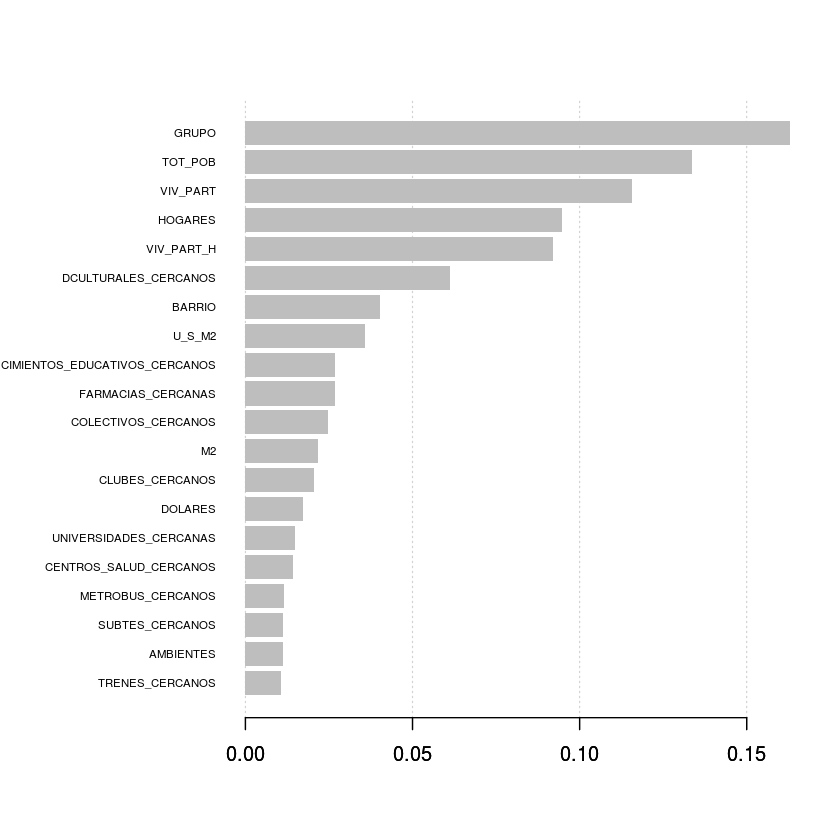

In [26]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(new_tr),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20])

In [27]:
resultado <- df_test
resultado$pred <- xgbpred

In [28]:
write.csv(resultado, file = "resultado.csv")

In [29]:
resultado2 <- resultado[resultado$pred == 1,c('LON','LAT')]

In [30]:
install.packages("ggmap")
library(ggmap)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [31]:
map <- qmap('-34.62, -58.43', zoom = 12, scale=2, extent="normal")

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=-34.62,+-58.43&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=-34.62,%20-58.43&sensor=false


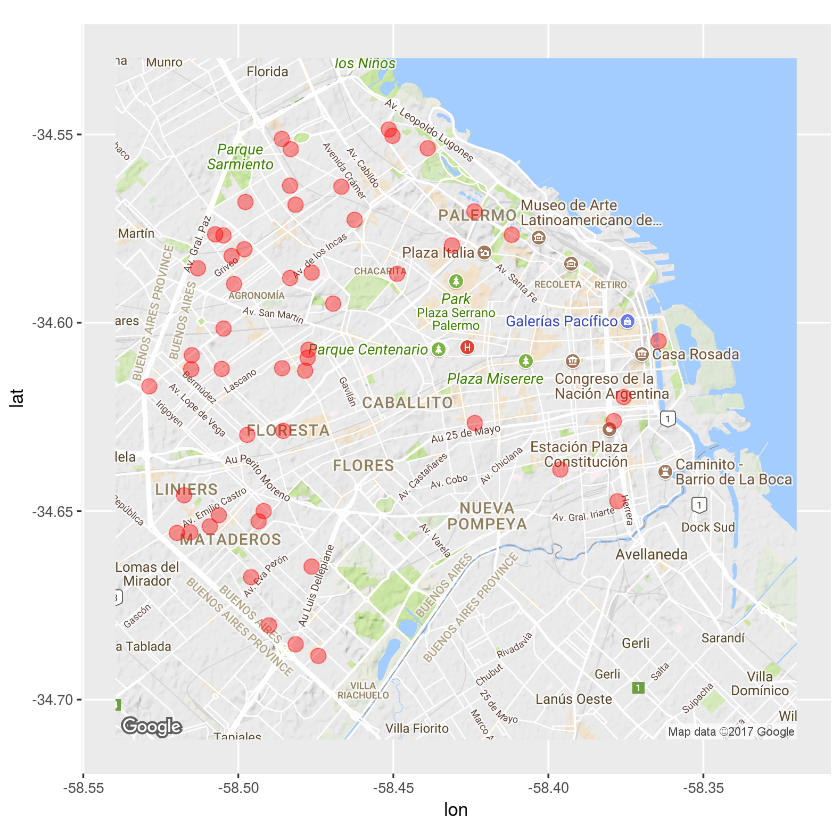

In [35]:
map + geom_point(data = resultado2, aes(x = LON, y = LAT), color="red", size=4, alpha=0.4)